In [17]:
from dgl import DGLGraph
import pandas as pd
from rdkit.Chem import MolFromSmiles
import numpy as np
from rdkit import Chem
import torch as th
from dgl.data.graph_serialize import save_graphs, load_graphs, load_labels
import torch
import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors


def find_var(df, min_value):
    df1 = df.copy()
    df1.loc["var"] = np.var(df1.values, axis=0)
    col = [x for i, x in enumerate(df1.columns)if df1.iat[-1, i] < min_value]
    return col


def find_sum_0(df):
    '''
    input: df
    return: the columns of labels with no positive labels
    '''
    df1 = df.copy()
    df1.loc["sum"] = np.sum(df1.values, axis=0)
    col = [x for i, x in enumerate(df1.columns)if df1.iat[-1, i] == 0]
    return col


def find_sum_1(df):
    '''
    input: df
    return: the columns of labels with no negative labels
    '''
    df1 = df.copy()
    df1.loc["sum"] = np.sum(df1.values, axis=0)
    col = [x for i, x in enumerate(df1.columns)if df1.iat[-1, i] == len(df)]
    return col


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_features(atom, explicit_H = False, use_chirality=True):
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'B',
        'C',
        'N',
        'O',
        'F',
        'Si',
        'P',
        'S',
        'Cl',
        'As',
        'Se',
        'Br',
        'Te',
        'I',
        'At',
        'other'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2,'other']) + [atom.GetIsAromatic()]
                # [atom.GetIsAromatic()] # set all aromaticity feature blank.
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                  [0, 1, 2, 3, 4])
    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
                atom.GetProp('_CIPCode'),
                ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                                 ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)


def one_of_k_atompair_encoding(x, allowable_set):
    for atompair in allowable_set:
        if x in atompair:
            x = atompair
            break
        else:
            if atompair == allowable_set[-1]:
                x = allowable_set[-1]
            else:
                continue
    return [x == s for s in allowable_set]


def bond_features(bond, use_chirality=True, atompair=False):
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    if atompair:
        atom_pair_str = bond.GetBeginAtom().GetSymbol() + bond.GetEndAtom().GetSymbol()
        bond_feats = bond_feats + one_of_k_atompair_encoding(
            atom_pair_str, [['CC'], ['CN', 'NC'], ['ON', 'NO'], ['CO', 'OC'], ['CS', 'SC'],
                            ['SO', 'OS'], ['NN'], ['SN', 'NS'], ['CCl', 'ClC'], ['CF', 'FC'],
                            ['CBr', 'BrC'], ['others']]
        )

    return np.array(bond_feats).astype(int)


def etype_features(bond, use_chirality=True, atompair=True):
    bt = bond.GetBondType()
    bond_feats_1 = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
    ]
    for i, m in enumerate(bond_feats_1):
        if m == True:
            a = i

    bond_feats_2 = bond.GetIsConjugated()
    if bond_feats_2 == True:
        b = 1
    else:
        b = 0

    bond_feats_3 = bond.IsInRing
    if bond_feats_3 == True:
        c = 1
    else:
        c = 0

    index = a * 1 + b * 4 + c * 8
    if use_chirality:
        bond_feats_4 = one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
        for i, m in enumerate(bond_feats_4):
            if m == True:
                d = i
        index = index + d * 16
    if atompair == True:
        atom_pair_str = bond.GetBeginAtom().GetSymbol() + bond.GetEndAtom().GetSymbol()
        bond_feats_5 = one_of_k_atompair_encoding(
            atom_pair_str, [['CC'], ['CN', 'NC'], ['ON', 'NO'], ['CO', 'OC'], ['CS', 'SC'],
                            ['SO', 'OS'], ['NN'], ['SN', 'NS'], ['CCl', 'ClC'], ['CF', 'FC'],
                            ['CBr', 'BrC'], ['others']]
        )
        for i, m in enumerate(bond_feats_5):
            if m == True:
                e = i
        index = index + e*64
    return index


def construct_RGCN_bigraph_from_smiles(smiles):
    g = DGLGraph()

    # Add nodes
    mol = MolFromSmiles(smiles)
    num_atoms = mol.GetNumAtoms()
    g.add_nodes(num_atoms)
    atoms_feature_all = []
    for atom_index, atom in enumerate(mol.GetAtoms()):
        atom_feature = atom_features(atom).tolist()
        atoms_feature_all.append(atom_feature)
    g.ndata["atom"] = torch.tensor(atoms_feature_all)



    # Add edges
    src_list = []
    dst_list = []
    etype_feature_all = []
    num_bonds = mol.GetNumBonds()
    for i in range(num_bonds):
        bond = mol.GetBondWithIdx(i)
        etype_feature = etype_features(bond)
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        src_list.extend([u, v])
        dst_list.extend([v, u])
        etype_feature_all.append(etype_feature)
        etype_feature_all.append(etype_feature)

    g.add_edges(src_list, dst_list)
    normal_all = []
    for i in etype_feature_all:
        normal = etype_feature_all.count(i)/len(etype_feature_all)
        normal = round(normal, 1)
        normal_all.append(normal)

    g.edata["etype"] = torch.tensor(etype_feature_all)
    g.edata["normal"] = torch.tensor(normal_all)
    return g


def binary_class_split(dataset, label_name):
    zero_dataset = []
    one_dataset = []
    for i in range(len(dataset)):
        if dataset[i][label_name] == 0:
            zero_dataset.append(dataset[i])
        else:
            one_dataset.append(dataset[i])
    return zero_dataset, one_dataset


def data_set_random_split(Dataset, shuffle=False):
    if shuffle:
        np.random.shuffle(Dataset)
    train_seq    = [i for i in range(len(Dataset)) if not i % 5 == 0]
    evaluate_seq = [i for i in range(len(Dataset)) if i % 5 == 0]
    training_set = []
    val_set = []
    test_set = []
    for i in train_seq:
        training_set.append(Dataset[i])
    for i in evaluate_seq:
        if i % 2 == 0:
            val_set.append(Dataset[i])
        else:
            test_set.append(Dataset[i])
    return training_set, val_set, test_set


def get_0_1_index(df, labels):
    col_zero = [i for i, x in enumerate(df[labels]) if x == 0]
    col_one = [i for i, x in enumerate(df[labels]) if x == 1]
    return col_zero, col_one


def split_dataset(dataset):
    train_seq = [x for x in range(len(dataset)) if not x % 5 == 0]
    evaluate_seq = [x for x in range(len(dataset)) if x % 5 == 0]
    val_seq = [x for x in evaluate_seq if not x % 2 == 0]
    test_seq = [x for x in evaluate_seq if x % 2 == 0]
    train_set = dataset.loc[train_seq].reset_index(drop=True)
    val_set = dataset.loc[val_seq].reset_index(drop=True)
    test_set = dataset.loc[test_seq].reset_index(drop=True)
    return train_set, val_set, test_set


def build_dataset(dataset_smiles, label_name, smiles_name, descriptor_seq, is_descriptor=True):
    dataset_gnn = []
    labels = dataset_smiles[label_name]
    smilesList = dataset_smiles[smiles_name]
    for i, smiles in enumerate(smilesList):
        if np.isnan(labels[i]):
            continue
        try:
            g = construct_RGCN_bigraph_from_smiles(smiles)
            if is_descriptor:
                molecule = [smiles, g, [labels[i]], dataset_smiles.loc[i][descriptor_seq], build_mask(labels)]
            else:
                molecule = [smiles, g, [labels[i]], build_mask(labels)]
            dataset_gnn.append(molecule)
        except:
            print('{} is transformed failed!'.format(smiles))
    return dataset_gnn


def build_mask(labels_list, mask_value=100):
    mask = []
    for i in labels_list:
        if i==mask_value:
            mask.append(0)
        else:
            mask.append(1)
    return mask


def multi_task_build_dataset(dataset_smiles, labels_list, smiles_name):
    dataset_gnn = []
    failed_molecule = []
    labels = dataset_smiles[labels_list]
    split_index = dataset_smiles['group']
    smilesList = dataset_smiles[smiles_name]
    molecule_number = len(smilesList)
    for i, smiles in enumerate(smilesList):
        try:
            g = construct_RGCN_bigraph_from_smiles(smiles)
            mask = build_mask(labels.loc[i], mask_value=123456)
            molecule = [smiles, g, labels.loc[i], mask, split_index.loc[i]]
            dataset_gnn.append(molecule)
            print('{}/{} molecule is transformed!'.format(i+1, molecule_number))
        except:
            print('{} is transformed failed!'.format(smiles))
            molecule_number = molecule_number - 1
            failed_molecule.append(smiles)
    print('{}({}) is transformed failed!'.format(failed_molecule, len(failed_molecule)))
    return dataset_gnn


def built_data_and_save_for_splited(
        origin_path='example.csv',
        save_path='example.bin',
        group_path='example_group.csv',
        task_list_selected=None,
         ):
    '''
        origin_path: str
            origin csv data set path, including molecule name, smiles, task
        save_path: str
            graph out put path
        group_path: str
            group out put path
        task_list_selected: list
            a list of selected task
        '''
    data_origin = pd.read_csv(origin_path)
    smiles_name = 'smiles'
    data_origin = data_origin.fillna(123456)
    labels_list = [x for x in data_origin.columns if x not in ['smiles', 'group']]
    if task_list_selected is not None:
        labels_list = task_list_selected
    data_set_gnn = multi_task_build_dataset(dataset_smiles=data_origin, labels_list=labels_list, smiles_name=smiles_name)

    smiles, graphs, labels, mask, split_index = map(list, zip(*data_set_gnn))
    graph_labels = {'labels': torch.tensor(labels),
                    'mask': torch.tensor(mask)
                    }
    split_index_pd = pd.DataFrame(columns=['smiles', 'group'])
    split_index_pd.smiles = smiles
    split_index_pd.group = split_index
    split_index_pd.to_csv(group_path, index=None, columns=None)
    print('Molecules graph is saved!')
    save_graphs(save_path, graphs, graph_labels)


def standardization_np(data, mean, std):
    return (data - mean) / (std + 1e-10)


def re_standar_np(data, mean, std):
    return data*(std + 1e-10)+mean
    

def split_dataset_according_index(dataset, train_index, val_index, test_index, data_type='np'):
    if data_type =='pd':
        return pd.DataFrame(dataset[train_index]), pd.DataFrame(dataset[val_index]), pd.DataFrame(dataset[test_index])
    if data_type =='np':
        return dataset[train_index], dataset[val_index], dataset[test_index]


def load_graph_from_csv_bin_for_splited(
        bin_path='example.bin',
        group_path='example.csv',
        select_task_index=None):
    smiles = pd.read_csv(group_path, index_col=None).smiles.values
    group = pd.read_csv(group_path, index_col=None).group.to_list()
    graphs, detailed_information = load_graphs(bin_path)
    labels = detailed_information['labels']
    mask = detailed_information['mask']
    if select_task_index is not None:
        labels = labels[:, select_task_index]
        mask = mask[:, select_task_index]
    # calculate not_use index
    notuse_mask = torch.mean(mask.float(), 1).numpy().tolist()
    not_use_index = []
    for index, notuse in enumerate(notuse_mask):
        if notuse==0:
            not_use_index.append(index)
    train_index=[]
    val_index = []
    test_index = []
    for index, group_index in enumerate(group):
        if group_index=='training' and index not in not_use_index:
            train_index.append(index)
        if group_index=='valid' and index not in not_use_index:
            val_index.append(index)
        if group_index == 'test' and index not in not_use_index:
            test_index.append(index)
    graph_List = []
    for g in graphs:
        graph_List.append(g)
    graphs_np = np.array(graphs)
    train_smiles, val_smiles, test_smiles = split_dataset_according_index(smiles, train_index, val_index, test_index)
    train_labels, val_labels, test_labels = split_dataset_according_index(labels.numpy(), train_index, val_index,
                                                                          test_index, data_type='pd')
    train_mask, val_mask, test_mask = split_dataset_according_index(mask.numpy(), train_index, val_index, test_index,
                                                                    data_type='pd')
    train_graph, val_graph, test_graph = split_dataset_according_index(graphs_np, train_index, val_index, test_index)

    # delete the 0_pos_label and 0_neg_label
    task_number = train_labels.values.shape[1]

    train_set = []
    val_set = []
    test_set = []
    for i in range(len(train_index)):
        molecule = [train_smiles[i], train_graph[i], train_labels.values[i], train_mask.values[i]]
        train_set.append(molecule)

    for i in range(len(val_index)):
        molecule = [val_smiles[i], val_graph[i], val_labels.values[i], val_mask.values[i]]
        val_set.append(molecule)

    for i in range(len(test_index)):
        molecule = [test_smiles[i], test_graph[i], test_labels.values[i], test_mask.values[i]]
        test_set.append(molecule)
    print(len(train_set), len(val_set), len(test_set),  task_number)
    return train_set, val_set, test_set, task_number

def construct_RGCN_bigraph_from_smiles_with_species_gender_exposure(smiles, species, exposure):
    g = DGLGraph()

    # Add nodes
    mol = MolFromSmiles(smiles)
    num_atoms = mol.GetNumAtoms()
    g.add_nodes(num_atoms)
    atoms_feature_all = []
###########################################################################################################    
    species_feature_all = []

    exposure_feature_all = []
    
    species_feature = [0]*8
    species_feature[species] = 1
    


    exposure_feature = [exposure]
    
    for atom_index, atom in enumerate(mol.GetAtoms()):
        atom_feature = atom_features(atom).tolist()
        atoms_feature_all.append(atom_feature)
############################################################################################################        
        species_feature_all.append(species_feature)
        exposure_feature_all.append(exposure_feature)
        
    atoms_tensor = torch.tensor(atoms_feature_all)
    
    species_tensor = torch.tensor(species_feature_all)
    exposure_tensor = torch.tensor(exposure_feature_all)

    node_features = torch.cat((atoms_tensor, species_tensor,exposure_tensor), dim=1)
    g.ndata["atom"] = node_features


    # Add edges
    src_list = []
    dst_list = []
    etype_feature_all = []
    num_bonds = mol.GetNumBonds()
    for i in range(num_bonds):
        bond = mol.GetBondWithIdx(i)
        etype_feature = etype_features(bond)
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        src_list.extend([u, v])
        dst_list.extend([v, u])
        etype_feature_all.append(etype_feature)
        etype_feature_all.append(etype_feature)

    g.add_edges(src_list, dst_list)
    normal_all = []
    for i in etype_feature_all:
        normal = etype_feature_all.count(i)/len(etype_feature_all)
        normal = round(normal, 1)
        normal_all.append(normal)

    g.edata["etype"] = torch.tensor(etype_feature_all)
    g.edata["normal"] = torch.tensor(normal_all)
    return g

def multi_task_build_dataset_with_species_gender_exposure(dataset_smiles, labels_list, smiles_name, species_list,exposure_list):
    dataset_gnn = []
    failed_molecule = []
    labels = dataset_smiles[labels_list]
    split_index = dataset_smiles['group']
    smilesList = dataset_smiles[smiles_name]
    molecule_number = len(smilesList)
    for i, smiles in enumerate(smilesList):
        try:
            #################################################################
            g = construct_RGCN_bigraph_from_smiles_with_species_gender_exposure(smiles, species_list[i], exposure_list[i])
            mask = build_mask(labels.loc[i], mask_value=123456)
            molecule = [smiles, g, labels.loc[i], mask, split_index.loc[i]]
            dataset_gnn.append(molecule)
            print('{}/{} molecule is transformed!'.format(i+1, molecule_number))
        except:
            print('{} is transformed failed!'.format(smiles))
            molecule_number = molecule_number - 1
            failed_molecule.append(smiles)
    print('{}({}) is transformed failed!'.format(failed_molecule, len(failed_molecule)))
    return dataset_gnn


def built_data_and_save_for_splited_with_species_gender_exposure(
        origin_path='example.csv',
        save_path='example.bin',
        group_path='example_group.csv',
        task_list_selected=None,
    ######################################################################################
        species_name='species',
        exposure_name='exposure'
         ):
    '''
        origin_path: str
            origin csv data set path, including molecule name, smiles, task
        save_path: str
            graph out put path
        group_path: str
            group out put path
        task_list_selected: list
            a list of selected task
        species_name: str
            the name of species column
        gender_name: str
            the name of gender column
        exposure_name: str
            the name of exposure column
        '''
    data_origin = pd.read_csv(origin_path)
    smiles_name = 'smiles'
    data_origin = data_origin.fillna(123456)
    labels_list = [x for x in data_origin.columns if x not in ['smiles', 'group', species_name, exposure_name]]
    if task_list_selected is not None:
        labels_list = task_list_selected
    data_set_gnn = multi_task_build_dataset_with_species_gender_exposure(dataset_smiles=data_origin, labels_list=labels_list, 
                                                                         smiles_name=smiles_name, 
                                                                         species_list=data_origin[species_name], 
                                                            
                                                                         exposure_list=data_origin[exposure_name])

    smiles, graphs, labels, mask, split_index = map(list, zip(*data_set_gnn))
    graph_labels = {'labels': torch.tensor(labels),
                    'mask': torch.tensor(mask)
                    }
    split_index_pd = pd.DataFrame(columns=['smiles', 'group'])
    split_index_pd.smiles = smiles
    split_index_pd.group = split_index
    split_index_pd.to_csv(group_path, index=None, columns=None)
    print('Molecules graph is saved!')
    save_graphs(save_path, graphs, graph_labels)

In [18]:
#权重导出
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDepictor, MolSurf
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns

sns.set(color_codes=True)


def weight_visulize_origin(smiles, atom_weight):
    print(smiles)
    mol = Chem.MolFromSmiles(smiles)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {}
    atom_raddi = {}
    # weight_norm = np.array(ind_weight).flatten()
    # threshold = weight_norm[np.argsort(weight_norm)[1]]
    # weight_norm = np.where(weight_norm < threshold, 0, weight_norm)
    
    for i in range(mol.GetNumAtoms()):
        if atom_weight[i] <= 0.3:
            atom_colors[i] = plt_colors.to_rgba(float(0.05))
        elif atom_weight[i] <= 0.4:
            atom_colors[i] = plt_colors.to_rgba(float(0.25))
        elif atom_weight[i] <= 0.5:
            atom_colors[i] = plt_colors.to_rgba(float(0.6))
        else:
            atom_colors[i] = plt_colors.to_rgba(float(1.0))
    rdDepictor.Compute2DCoords(mol)
    
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(0, mol.GetNumAtoms()), highlightBonds=[],
                        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:', '')
    svg3 = SVG(svg2)
    display(svg3)


def weight_visulize(smiles, atom_weight):
    print(smiles)
    atom_weight_list = atom_weight.cpu().squeeze().numpy().tolist()
    max_atom_weight_index = atom_weight_list.index(max(atom_weight_list))
    significant_weight = atom_weight[max_atom_weight_index]
    mol = Chem.MolFromSmiles(smiles)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {}
    bond_colors = {}
    # weight_norm = np.array(ind_weight).flatten()
    # threshold = weight_norm[np.argsort(weight_norm)[1]]
    # weight_norm = np.where(weight_norm < threshold, 0, weight_norm)
    atom_new_weight = [0 for x in range(mol.GetNumAtoms())]
    # generate most important significant circle fragment and attach significant weight
    atom = mol.GetAtomWithIdx(max_atom_weight_index)
    # # find neighbors 1
    atom_neighbors_1 = [x.GetIdx() for x in atom.GetNeighbors()]
    # find neighbors 2
    atom_neighbors_2 = []
    for neighbors_1_index in atom_neighbors_1:
        neighbor_1_atom = mol.GetAtomWithIdx(neighbors_1_index)
        atom_neighbors_2 = atom_neighbors_2 + [x.GetIdx() for x in neighbor_1_atom.GetNeighbors()]
    atom_neighbors_2.remove(max_atom_weight_index)
    # find neighbors 3
    atom_neighbors_3 = []
    for neighbors_2_index in atom_neighbors_2:
        neighbor_2_atom = mol.GetAtomWithIdx(neighbors_2_index)
        atom_neighbors_3 = atom_neighbors_3 + [x.GetIdx() for x in neighbor_2_atom.GetNeighbors()]
    atom_neighbors_3 = [x for x in atom_neighbors_3 if x not in atom_neighbors_1]
    # attach neighbor 3 significant weight
    for i in atom_neighbors_3:
        atom_new_weight[i] = significant_weight*0.5
    for i in atom_neighbors_2:
        atom_new_weight[i] = significant_weight
    for i in atom_neighbors_1:
        atom_new_weight[i] = significant_weight
    atom_new_weight[max_atom_weight_index] = significant_weight

    significant_fg_index = [max_atom_weight_index] + atom_neighbors_1 + atom_neighbors_2 + atom_neighbors_3

    for i in range(mol.GetNumAtoms()):
        atom_colors[i] = plt_colors.to_rgba(float(atom_new_weight[i]))

    for i in range(mol.GetNumBonds()):
        bond = mol.GetBondWithIdx(i)
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        x = atom_new_weight[u]
        y = atom_new_weight[v]
        bond_weight = (x+y)/2
        if u in significant_fg_index and v in significant_fg_index:
            bond_colors[i] = plt_colors.to_rgba(float(abs(bond_weight)))
        else:
            bond_colors[i] = plt_colors.to_rgba(float(abs(0)))
    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(0, mol.GetNumAtoms()), highlightBonds=range(0, mol.GetNumBonds()),
                        highlightAtomColors=atom_colors, highlightBondColors=bond_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:', '')
    svg3 = SVG(svg2)
    display(svg3)


def weight_visulize_py(smiles, atom_weight,):
    print(smiles)
    atom_weight_list = atom_weight.cpu().squeeze().numpy().tolist()
    max_atom_weight_index = atom_weight_list.index(max(atom_weight_list))
    significant_weight = atom_weight[max_atom_weight_index]
    mol = Chem.MolFromSmiles(smiles)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {}
    bond_colors = {}
    # weight_norm = np.array(ind_weight).flatten()
    # threshold = weight_norm[np.argsort(weight_norm)[1]]
    # weight_norm = np.where(weight_norm < threshold, 0, weight_norm)
    atom_new_weight = [0 for x in range(mol.GetNumAtoms())]
    # generate most important significant circle fragment and attach significant weight
    atom = mol.GetAtomWithIdx(max_atom_weight_index)
    # # find neighbors 1
    atom_neighbors_1 = [x.GetIdx() for x in atom.GetNeighbors()]
    # find neighbors 2
    atom_neighbors_2 = []
    for neighbors_1_index in atom_neighbors_1:
        neighbor_1_atom = mol.GetAtomWithIdx(neighbors_1_index)
        atom_neighbors_2 = atom_neighbors_2 + [x.GetIdx() for x in neighbor_1_atom.GetNeighbors()]
    atom_neighbors_2.remove(max_atom_weight_index)
    # find neighbors 3
    atom_neighbors_3 = []
    for neighbors_2_index in atom_neighbors_2:
        neighbor_2_atom = mol.GetAtomWithIdx(neighbors_2_index)
        atom_neighbors_3 = atom_neighbors_3 + [x.GetIdx() for x in neighbor_2_atom.GetNeighbors()]
    atom_neighbors_3 = [x for x in atom_neighbors_3 if x not in atom_neighbors_1]
    # attach neighbor 3 significant weight
    for i in atom_neighbors_3:
        atom_new_weight[i] = significant_weight*0.5
    for i in atom_neighbors_2:
        atom_new_weight[i] = significant_weight
    for i in atom_neighbors_1:
        atom_new_weight[i] = significant_weight
    atom_new_weight[max_atom_weight_index] = significant_weight

    significant_fg_index = [max_atom_weight_index] + atom_neighbors_1 + atom_neighbors_2 + atom_neighbors_3

    for i in range(mol.GetNumAtoms()):
        atom_colors[i] = plt_colors.to_rgba(float(atom_new_weight[i]))

    for i in range(mol.GetNumBonds()):
        bond = mol.GetBondWithIdx(i)
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        x = atom_new_weight[u]
        y = atom_new_weight[v]
        bond_weight = (x+y)/2
        if u in significant_fg_index and v in significant_fg_index:
            bond_colors[i] = plt_colors.to_rgba(float(abs(bond_weight)))
        else:
            bond_colors[i] = plt_colors.to_rgba(float(abs(0)))
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    smiles_name = eval(repr(smiles).replace('\\', '|'))
    MolToFile(mol, r'./CYP2D6/'+smiles_name+'.png', highlightAtoms=range(0, mol.GetNumAtoms()), highlightBonds=range(0, mol.GetNumBonds()),
              highlightAtomColors=atom_colors, highlightBondColors=bond_colors)

In [19]:
# generate hERG dataset
args={}
args['input_csv'] = 'D:/科研/data/zhu.csv'
args['output_bin'] = 'D:/科研/data/zhu.bin'
args['output_csv'] = 'D:/科研/data/zhu_group.csv'

built_data_and_save_for_splited_with_species_gender_exposure(
        origin_path=args['input_csv'],
        save_path=args['output_bin'],
        group_path=args['output_csv'],
        task_list_selected=None
         )

E:\Anaconda\envs\pytorch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


1/91295 molecule is transformed!
2/91295 molecule is transformed!
3/91295 molecule is transformed!
4/91295 molecule is transformed!
5/91295 molecule is transformed!
6/91295 molecule is transformed!
7/91295 molecule is transformed!
8/91295 molecule is transformed!
9/91295 molecule is transformed!
10/91295 molecule is transformed!
11/91295 molecule is transformed!
12/91295 molecule is transformed!
13/91295 molecule is transformed!
14/91295 molecule is transformed!
15/91295 molecule is transformed!
16/91295 molecule is transformed!
17/91295 molecule is transformed!
18/91295 molecule is transformed!
19/91295 molecule is transformed!
20/91295 molecule is transformed!
21/91295 molecule is transformed!
22/91295 molecule is transformed!
23/91295 molecule is transformed!
24/91295 molecule is transformed!
25/91295 molecule is transformed!
26/91295 molecule is transformed!
27/91295 molecule is transformed!
28/91295 molecule is transformed!
29/91295 molecule is transformed!
30/91295 molecule is tr

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6204\2965324300.py:554: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_labels = {'labels': torch.tensor(labels),


Molecules graph is saved!


2295/3019 molecule is transformed!
2296/3019 molecule is transformed!
2297/3019 molecule is transformed!
2298/3019 molecule is transformed!
2299/3019 molecule is transformed!
2300/3019 molecule is transformed!
2301/3019 molecule is transformed!
2302/3019 molecule is transformed!
2303/3019 molecule is transformed!
2304/3019 molecule is transformed!
2305/3019 molecule is transformed!
2306/3019 molecule is transformed!
2307/3019 molecule is transformed!
2308/3019 molecule is transformed!
2309/3019 molecule is transformed!
2310/3019 molecule is transformed!
2311/3019 molecule is transformed!
2312/3019 molecule is transformed!
2313/3019 molecule is transformed!
2314/3019 molecule is transformed!
2315/3019 molecule is transformed!
2316/3019 molecule is transformed!
2317/3019 molecule is transformed!
2318/3019 molecule is transformed!
2319/3019 molecule is transformed!
2320/3019 molecule is transformed!
2321/3019 molecule is transformed!
2322/3019 molecule is transformed!
2323/3019 molecule i

2577/3019 molecule is transformed!
2578/3019 molecule is transformed!
2579/3019 molecule is transformed!
2580/3019 molecule is transformed!
2581/3019 molecule is transformed!
2582/3019 molecule is transformed!
2583/3019 molecule is transformed!
2584/3019 molecule is transformed!
2585/3019 molecule is transformed!
2586/3019 molecule is transformed!
2587/3019 molecule is transformed!
2588/3019 molecule is transformed!
2589/3019 molecule is transformed!
2590/3019 molecule is transformed!
2591/3019 molecule is transformed!
2592/3019 molecule is transformed!
2593/3019 molecule is transformed!
2594/3019 molecule is transformed!
2595/3019 molecule is transformed!
2596/3019 molecule is transformed!
2597/3019 molecule is transformed!
2598/3019 molecule is transformed!
2599/3019 molecule is transformed!
2600/3019 molecule is transformed!
2601/3019 molecule is transformed!
2602/3019 molecule is transformed!
2603/3019 molecule is transformed!
2604/3019 molecule is transformed!
2605/3019 molecule i

2842/3019 molecule is transformed!
2843/3019 molecule is transformed!
2844/3019 molecule is transformed!
2845/3019 molecule is transformed!
2846/3019 molecule is transformed!
2847/3019 molecule is transformed!
2848/3019 molecule is transformed!
2849/3019 molecule is transformed!
2850/3019 molecule is transformed!
2851/3019 molecule is transformed!
2852/3019 molecule is transformed!
2853/3019 molecule is transformed!
2854/3019 molecule is transformed!
2855/3019 molecule is transformed!
2856/3019 molecule is transformed!
2857/3019 molecule is transformed!
2858/3019 molecule is transformed!
2859/3019 molecule is transformed!
2860/3019 molecule is transformed!
2861/3019 molecule is transformed!
2862/3019 molecule is transformed!
2863/3019 molecule is transformed!
2864/3019 molecule is transformed!
2865/3019 molecule is transformed!
2866/3019 molecule is transformed!
2867/3019 molecule is transformed!
2868/3019 molecule is transformed!
2869/3019 molecule is transformed!
2870/3019 molecule i

In [20]:
import datetime
from sklearn.metrics import roc_auc_score, mean_squared_error, precision_recall_curve, auc, r2_score
import torch
import torch.nn.functional as F
import dgl
import numpy as np
import random
from dgl.readout import sum_nodes
from dgl.nn.pytorch.conv import RelGraphConv
from torch import nn
import pandas as pd



class WeightAndSum(nn.Module):
    def __init__(self, in_feats, task_num=1, attention=True, return_weight=False):
        super(WeightAndSum, self).__init__()
        self.attention = attention
        self.in_feats = in_feats
        self.task_num = task_num
        self.return_weight=return_weight
        self.atom_weighting_specific = nn.ModuleList([self.atom_weight(self.in_feats) for _ in range(self.task_num)])
        self.shared_weighting = self.atom_weight(self.in_feats)
    def forward(self, bg, feats):
        feat_list = []
        atom_list = []
        # cal specific feats
        for i in range(self.task_num):
            with bg.local_scope():
                bg.ndata['h'] = feats
                weight = self.atom_weighting_specific[i](feats)
                bg.ndata['w'] = weight
                specific_feats_sum = sum_nodes(bg, 'h', 'w')
                atom_list.append(bg.ndata['w'])
            feat_list.append(specific_feats_sum)

        # cal shared feats
        with bg.local_scope():
            bg.ndata['h'] = feats
            bg.ndata['w'] = self.shared_weighting(feats)
            shared_feats_sum = sum_nodes(bg, 'h', 'w')
        # feat_list.append(shared_feats_sum)
        if self.attention:
            if self.return_weight:
                return feat_list, atom_list
            else:
                return feat_list
        else:
            return shared_feats_sum

    def atom_weight(self, in_feats):
        return nn.Sequential(
            nn.Linear(in_feats, 1),
            nn.Sigmoid()
            )


class MLPBinaryClassifier(nn.Module):
    def __init__(self, in_feats, hidden_feats, n_tasks, dropout=0.):
        super(MLPBinaryClassifier, self).__init__()

        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, hidden_feats),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_feats),
            nn.Linear(hidden_feats, n_tasks)
        )

    def forward(self, h):
        return self.predict(h)


class RGCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_rels=64*21, activation=F.relu, loop=False,
                 residual=True, batchnorm=True, rgcn_drop_out=0.5):
        super(RGCNLayer, self).__init__()

        self.activation = activation
        self.graph_conv_layer = RelGraphConv(in_feats, out_feats, num_rels=num_rels, regularizer='basis',
                                               num_bases=None, bias=True, activation=activation,
                                               self_loop=loop, dropout=rgcn_drop_out)
        self.residual = residual
        if residual:
            self.res_connection = nn.Linear(in_feats, out_feats)

        self.bn = batchnorm
        if batchnorm:
            self.bn_layer = nn.BatchNorm1d(out_feats)

    def forward(self, bg, node_feats, etype, norm=None):
        """Update atom representations
        Parameters
        ----------
        bg : BatchedDGLGraph
            Batched DGLGraphs for processing multiple molecules in parallel
        node_feats : FloatTensor of shape (N, M1)
            * N is the total number of atoms in the batched graph
            * M1 is the input atom feature size, must match in_feats in initialization
        etype: int
            bond type
        norm: torch.Tensor
            Optional edge normalizer tensor. Shape: :math:`(|E|, 1)`
        Returns
        -------
        new_feats : FloatTensor of shape (N, M2)
            * M2 is the output atom feature size, must match out_feats in initialization
        """
        new_feats = self.graph_conv_layer(bg, node_feats, etype, norm)
        if self.residual:
            res_feats = self.activation(self.res_connection(node_feats))
            new_feats = new_feats + res_feats
        if self.bn:
            new_feats = self.bn_layer(new_feats)
        del res_feats
        torch.cuda.empty_cache()
        return new_feats


class BaseGNN(nn.Module):
    def __init__(self, gnn_out_feats, n_tasks, rgcn_drop_out=0.5, return_mol_embedding=False, return_weight=False,
                 classifier_hidden_feats=128, dropout=0.):
        super(BaseGNN, self).__init__()
        self.task_num = n_tasks
        self.gnn_layers = nn.ModuleList()
        self.return_weight = return_weight
        self.weighted_sum_readout = WeightAndSum(gnn_out_feats, self.task_num, return_weight=self.return_weight)
        self.fc_in_feats = gnn_out_feats
        self.return_mol_embedding=return_mol_embedding

        self.fc_layers1 = nn.ModuleList([self.fc_layer(dropout, self.fc_in_feats, classifier_hidden_feats) for _ in range(self.task_num)])
        self.fc_layers2 = nn.ModuleList(
            [self.fc_layer(dropout, classifier_hidden_feats, classifier_hidden_feats) for _ in range(self.task_num)])
        self.fc_layers3 = nn.ModuleList(
            [self.fc_layer(dropout, classifier_hidden_feats, classifier_hidden_feats) for _ in range(self.task_num)])

        self.output_layer1 = nn.ModuleList(
            [self.output_layer(classifier_hidden_feats, 1) for _ in range(self.task_num)])

    def forward(self, bg, node_feats, etype, norm=None):
        # Update atom features with GNNs
        for gnn in self.gnn_layers:
            node_feats = gnn(bg, node_feats, etype, norm)

        # Compute molecule features from atom features
        if self.return_weight:
            feats_list, atom_weight_list = self.weighted_sum_readout(bg, node_feats)
        else:
            feats_list = self.weighted_sum_readout(bg, node_feats)

        for i in range(self.task_num):
            # mol_feats = torch.cat([feats_list[-1], feats_list[i]], dim=1)
            mol_feats = feats_list[i]
            h1 = self.fc_layers1[i](mol_feats)
            h2 = self.fc_layers2[i](h1)
            h3 = self.fc_layers3[i](h2)
            predict = self.output_layer1[i](h3)
            if i == 0:
                prediction_all = predict
            else:
                prediction_all = torch.cat([prediction_all, predict], dim=1)
        # generate toxicity fingerprints
        if self.return_mol_embedding:
            return feats_list[0]
        else:
            # generate atom weight and atom feats
            if self.return_weight:
                return prediction_all, atom_weight_list, node_feats
            # just generate prediction
            return prediction_all

    def fc_layer(self, dropout, in_feats, hidden_feats):
        return nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_feats, hidden_feats),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_feats)
                )

    def output_layer(self, hidden_feats, out_feats):
        return nn.Sequential(
                nn.Linear(hidden_feats, out_feats)
                )


class MGA(BaseGNN):
    def __init__(self, in_feats, rgcn_hidden_feats, n_tasks, return_weight=False,
                 classifier_hidden_feats=128, loop=False, return_mol_embedding=False,
                 rgcn_drop_out=0.5, dropout=0.):
        super(MGA, self).__init__(gnn_out_feats=rgcn_hidden_feats[-1],
                                  n_tasks=n_tasks,
                                  classifier_hidden_feats=classifier_hidden_feats,
                                  return_mol_embedding=return_mol_embedding,
                                  return_weight=return_weight,
                                  rgcn_drop_out=rgcn_drop_out,
                                  dropout=dropout,
                                  )

        for i in range(len(rgcn_hidden_feats)):
            out_feats = rgcn_hidden_feats[i]
            self.gnn_layers.append(RGCNLayer(in_feats, out_feats, loop=loop, rgcn_drop_out=rgcn_drop_out))
            in_feats = out_feats


def set_random_seed(seed=10):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def pos_weight(train_set, classification_num):
    smiles, graphs, labels, mask = map(list, zip(*train_set))
    labels = np.array(labels)
    task_pos_weight_list = []
    for task in range(classification_num):
        num_pos = 0
        num_impos = 0
        for i in labels[:, task]:
            if i == 1:
                num_pos = num_pos + 1
            if i == 0:
                num_impos = num_impos + 1
        weight = num_impos / (num_pos+0.00000001)
        task_pos_weight_list.append(weight)
    task_pos_weight = torch.tensor(task_pos_weight_list)
    return task_pos_weight


class Meter(object):
    """Track and summarize model performance on a dataset for
    (multi-label) binary classification."""
    def __init__(self):
        self.mask = []
        self.y_pred = []
        self.y_true = []

    def update(self, y_pred, y_true, mask):
        """Update for the result of an iteration
        Parameters
        ----------
        y_pred : float32 tensor
            Predicted molecule labels with shape (B, T),
            B for batch size and T for the number of tasks
        y_true : float32 tensor
            Ground truth molecule labels with shape (B, T)
        mask : float32 tensor
            Mask for indicating the existence of ground
            truth labels with shape (B, T)
        """
        self.y_pred.append(y_pred.detach().cpu())
        self.y_true.append(y_true.detach().cpu())
        self.mask.append(mask.detach().cpu())

    def roc_auc_score(self):
        """Compute roc-auc score for each task.
        Returns
        -------
        list of float
            roc-auc score for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        # Todo: support categorical classes
        # This assumes binary case only
        y_pred = torch.sigmoid(y_pred)
        n_tasks = y_true.shape[1]
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            scores.append(round(roc_auc_score(task_y_true, task_y_pred), 4))
        return scores

    def return_pred_true(self):
        """Compute roc-auc score for each task.
        Returns
        -------
        list of float
            roc-auc score for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        # Todo: support categorical classes
        # This assumes binary case only
        y_pred = torch.sigmoid(y_pred)
        n_tasks = y_true.shape[1]
        scores = []
        return y_pred, y_true

    def return_pred_true_re(self):
        """Return predicted and true values for regression."""
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        return y_pred, y_true

    def l1_loss(self, reduction):
        """Compute l1 loss for each task.
        Returns
        -------
        list of float
            l1 loss for all tasks
        reduction : str
            * 'mean': average the metric over all labeled data points for each task
            * 'sum': sum the metric over all labeled data points for each task
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        n_tasks = y_true.shape[1]
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            scores.append(F.l1_loss(task_y_true, task_y_pred, reduction=reduction).item())
        return scores

    def rmse(self):
        """Compute RMSE for each task.
        Returns
        -------
        list of float
            rmse for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        n_data, n_tasks = y_true.shape
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            scores.append(np.sqrt(F.mse_loss(task_y_pred, task_y_true).cpu().item()))
        return scores

    def mae(self):
        """Compute MAE for each task.
        Returns
        -------
        list of float
            mae for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        n_data, n_tasks = y_true.shape
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            scores.append(mean_squared_error(task_y_true, task_y_pred))
        return scores

    def r2(self):
        """Compute R2 for each task.
        Returns
        -------
        list of float
            r2 for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        n_data, n_tasks = y_true.shape
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            scores.append(round(r2_score(task_y_true, task_y_pred), 4))
        return scores

    def roc_precision_recall_score(self):
        """Compute AUC_PRC for each task.
        Returns
        -------
        list of float
            AUC_PRC for all tasks
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)
        # Todo: support categorical classes
        # This assumes binary case only
        y_pred = torch.sigmoid(y_pred)
        n_tasks = y_true.shape[1]
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0].numpy()
            task_y_pred = y_pred[:, task][task_w != 0].numpy()
            precision, recall, _thresholds = precision_recall_curve(task_y_true, task_y_pred)
            scores.append(auc(recall, precision))
        return scores

    def compute_metric(self, metric_name, reduction='mean'):
        """Compute metric for each task.
        Parameters
        ----------
        metric_name : str
            Name for the metric to compute.
        reduction : str
            Only comes into effect when the metric_name is l1_loss.
            * 'mean': average the metric over all labeled data points for each task
            * 'sum': sum the metric over all labeled data points for each task
        Returns
        -------
        list of float
            Metric value for each task
        """
        assert metric_name in ['roc_auc', 'l1', 'rmse', 'mae', 'roc_prc', 'r2', 'return_pred_true'], \
            'Expect metric name to be "roc_auc", "l1" or "rmse", "mae", "roc_prc", "r2", "return_pred_true", got {}'.format(metric_name)
        assert reduction in ['mean', 'sum']
        if metric_name == 'roc_auc':
            return self.roc_auc_score()
        if metric_name == 'l1':
            return self.l1_loss(reduction)
        if metric_name == 'rmse':
            return self.rmse()
        if metric_name == 'mae':
            return self.mae()
        if metric_name == 'roc_prc':
            return self.roc_precision_recall_score()
        if metric_name == 'r2':
            return self.r2()
        if metric_name == 'return_pred_true':
            return self.return_pred_true()


def collate_molgraphs(data):
    smiles, graphs, labels, mask = map(list, zip(*data))
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.tensor(labels)
    mask = torch.tensor(mask)

    return smiles, bg, labels,  mask


def run_a_train_epoch_heterogeneous(args, epoch, model, data_loader, loss_criterion_c, loss_criterion_r, optimizer, task_weight=None):
    model.train()
    train_meter_c = Meter()
    train_meter_r = Meter()
    if task_weight is not None:
        task_weight = task_weight.float().to(args['device'])

    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, mask = batch_data
        mask = mask.float().to(args['device'])
        labels.float().to(args['device'])
        atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
        bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
        bg = bg.to(args['device'])
        logits = model(bg, atom_feats, bond_feats, norm=None)
        labels = labels.type_as(logits).to(args['device'])
        # calculate loss according to different task class
        if args['task_class'] == 'classification_regression':
            # split classification and regression
            logits_c = logits[:,:args['classification_num']]
            labels_c = labels[:,:args['classification_num']]
            mask_c = mask[:,:args['classification_num']]

            logits_r = logits[:,args['classification_num']:]
            labels_r = labels[:,args['classification_num']:]
            mask_r = mask[:,args['classification_num']:]
            # chose loss function according to task_weight
            if task_weight is None:
                loss = (loss_criterion_c(logits_c, labels_c)*(mask_c != 0).float()).mean() \
                       + (loss_criterion_r(logits_r, labels_r)*(mask_r != 0).float()).mean()
            else:
                task_weight_c = task_weight[:args['classification_num']]
                task_weight_r = task_weight[args['classification_num']:]
                loss = (torch.mean(loss_criterion_c(logits_c, labels_c)*(mask_c != 0).float(), dim=0)*task_weight_c).mean() \
                       + (torch.mean(loss_criterion_r(logits_r, labels_r)*(mask_r != 0).float(), dim=0)*task_weight_r).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print('epoch {:d}/{:d}, batch {:d}/{:d}, loss {:.4f}'.format(
            #     epoch + 1, args['num_epochs'], batch_id + 1, len(data_loader), loss.item()))
            train_meter_c.update(logits_c, labels_c, mask_c)
            train_meter_r.update(logits_r, labels_r, mask_r)
            del bg, mask, labels, atom_feats, bond_feats, loss, logits_c, logits_r, labels_c, labels_r, mask_c, mask_r
            torch.cuda.empty_cache()
        elif args['task_class'] == 'classification':
            # chose loss function according to task_weight
            if task_weight is None:
                loss = (loss_criterion_c(logits, labels)*(mask != 0).float()).mean()
            else:
                loss = (torch.mean(loss_criterion_c(logits, labels) * (mask != 0).float(),dim=0)*task_weight).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print('epoch {:d}/{:d}, batch {:d}/{:d}, loss {:.4f}'.format(
            #     epoch + 1, args['num_epochs'], batch_id + 1, len(data_loader), loss.item()))
            train_meter_c.update(logits, labels, mask)
            del bg, mask, labels, atom_feats, bond_feats, loss,  logits
            torch.cuda.empty_cache()
        else:
            # chose loss function according to task_weight
            if task_weight is None:
                loss = (loss_criterion_r(logits, labels)*(mask != 0).float()).mean()
            else:
                loss = (torch.mean(loss_criterion_r(logits, labels) * (mask != 0).float(), dim=0)*task_weight).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print('epoch {:d}/{:d}, batch {:d}/{:d}, loss {:.4f}'.format(
            #     epoch + 1, args['num_epochs'], batch_id + 1, len(data_loader), loss.item()))
            train_meter_r.update(logits, labels, mask)
            del bg, mask, labels, atom_feats, bond_feats, loss,  logits
            torch.cuda.empty_cache()
    if args['task_class'] == 'classification_regression':
        train_score = np.mean(train_meter_c.compute_metric(args['classification_metric_name']) +
                              train_meter_r.compute_metric(args['regression_metric_name']))
        print('epoch {:d}/{:d}, training {} {:.4f}'.format(
            epoch + 1, args['num_epochs'], 'r2+auc', train_score))
    elif args['task_class'] == 'classification':
        train_score = np.mean(train_meter_c.compute_metric(args['classification_metric_name']))
        print('epoch {:d}/{:d}, training {} {:.4f}'.format(
            epoch + 1, args['num_epochs'], args['classification_metric_name'], train_score))
    else:
        train_score = np.mean(train_meter_r.compute_metric(args['regression_metric_name']))
        print('epoch {:d}/{:d}, training {} {:.4f}'.format(
            epoch + 1, args['num_epochs'], args['regression_metric_name'], train_score))


def run_an_eval_epoch_heterogeneous(args, model, data_loader):
    model.eval()
    eval_meter_c = Meter()
    eval_meter_r = Meter()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            labels = labels.float().to(args['device'])
            mask = mask.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits = model(bg, atom_feats, bond_feats, norm=None)
            labels = labels.type_as(logits).to(args['device'])
            if args['task_class'] == 'classification_regression':
                # split classification and regression
                logits_c = logits[:, :args['classification_num']]
                labels_c = labels[:, :args['classification_num']]
                mask_c = mask[:, :args['classification_num']]
                logits_r = logits[:, args['classification_num']:]
                labels_r = labels[:, args['classification_num']:]
                mask_r = mask[:, args['classification_num']:]
                # Mask non-existing labels
                eval_meter_c.update(logits_c, labels_c, mask_c)
                eval_meter_r.update(logits_r, labels_r, mask_r)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits_c, logits_r, labels_c, labels_r, mask_c, mask_r
                torch.cuda.empty_cache()
            elif args['task_class'] == 'classification':
                # Mask non-existing labels
                eval_meter_c.update(logits, labels, mask)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits
                torch.cuda.empty_cache()
            else:
                # Mask non-existing labels
                eval_meter_r.update(logits, labels, mask)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits
                torch.cuda.empty_cache()
        if args['task_class'] == 'classification_regression':
            return eval_meter_c.compute_metric(args['classification_metric_name']) + \
                   eval_meter_r.compute_metric(args['regression_metric_name'])
        elif args['task_class'] == 'classification':
            return eval_meter_c.compute_metric(args['classification_metric_name'])
        else:
            return eval_meter_r.compute_metric(args['regression_metric_name'])


def run_an_eval_epoch_pih(args, model, data_loader, output_path):
    model.eval()
    eval_meter_c = Meter()
    eval_meter_r = Meter()
    smiles_list = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            smiles_list = smiles_list + smiles
            labels = labels.float().to(args['device'])
            mask = mask.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits = model(bg, atom_feats, bond_feats, norm=None)
            labels = labels.type_as(logits).to(args['device'])
            if args['task_class'] == 'classification_regression':
                # split classification and regression
                logits_c = logits[:, :args['classification_num']]
                labels_c = labels[:, :args['classification_num']]
                mask_c = mask[:, :args['classification_num']]
                logits_r = logits[:, args['classification_num']:]
                labels_r = labels[:, args['classification_num']:]
                mask_r = mask[:, args['classification_num']:]
                # Mask non-existing labels
                eval_meter_c.update(logits_c, labels_c, mask_c)
                eval_meter_r.update(logits_r, labels_r, mask_r)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits_c, logits_r, labels_c, labels_r, mask_c, mask_r
                torch.cuda.empty_cache()
            elif args['task_class'] == 'classification':
                # Mask non-existing labels
                eval_meter_c.update(logits, labels, mask)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits
                torch.cuda.empty_cache()
            else:
                # Mask non-existing labels
                eval_meter_r.update(logits, labels, mask)
                del smiles, bg,  mask, labels, atom_feats, bond_feats, logits
                torch.cuda.empty_cache()
        if args['task_class'] == 'classification_regression':
            return eval_meter_c.compute_metric(args['classification_metric_name']) + \
                   eval_meter_r.compute_metric(args['regression_metric_name'])
        elif args['task_class'] == 'classification':
            y_pred, y_true = eval_meter_c.compute_metric('return_pred_true')
            result = pd.DataFrame(columns=['smiles', 'pred', 'true'])
            result['smiles'] = smiles_list
            result['pred'] = np.squeeze(y_pred.numpy()).tolist()
            result['true'] = np.squeeze(y_true.numpy()).tolist()
            result.to_csv(output_path, index=None)
        else:
            # 获取回归任务的预测结果和真实标签
            y_pred, y_true = eval_meter_r.compute_metric('return_pred_true')
            # 创建一个DataFrame来存储预测结果和真实标签
            result = pd.DataFrame(columns=['smiles', 'pred', 'true'])
            # 将SMILES信息添加到DataFrame中
            result['smiles'] = smiles_list
            # 将预测结果和真实标签添加到DataFrame中
            result['pred'] = np.squeeze(y_pred.numpy()).tolist()
            result['true'] = np.squeeze(y_true.numpy()).tolist()
            # 将DataFrame写入csv文件中
            result.to_csv(output_path, index=None)
            
def run_an_eval_epoch_re(args, model, data_loader, output_path):
    model.eval()
    eval_meter_r = Meter()
    smiles_list = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            smiles_list = smiles_list + smiles
            labels = labels.float().to(args['device'])
            mask = mask.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits = model(bg, atom_feats, bond_feats, norm=None).to(args['device'])
            labels = labels.type_as(logits).to(args['device'])
            # Mask non-existing labels
            eval_meter_r.update(logits, labels, mask)
            del smiles, bg, mask, labels, atom_feats, bond_feats, logits
            torch.cuda.empty_cache()

        y_pred, y_true = eval_meter_r.return_pred_true_re()

        result = pd.DataFrame(columns=['smiles', 'pred', 'true'])
        result['smiles'] = smiles_list
        result['pred'] = np.squeeze(y_pred.numpy()).tolist()
        result['true'] = np.squeeze(y_true.numpy()).tolist()
        result.to_csv(output_path, index=None)
        
        return y_pred
        


def run_an_eval_epoch_heterogeneous_return_weight(args, model, data_loader, vis_list=None, vis_task='can'):
    model.eval()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            #####
            labels = labels.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits, atom_weight_list, node_feats = model(bg, atom_feats, bond_feats, norm=None)
            labels = labels.type_as(logits).to(args['device'])
            logits_c = logits[:, :args['classification_num']]
            logits_c = torch.sigmoid(logits_c)
            # different tasks with different atom weight

            for mol_index in range(len(smiles)):
                atom_smiles = smiles[mol_index]
                if atom_smiles in vis_list:
                    for tasks_index in range(1):
                        if args['all_task_list'][tasks_index] == vis_task:
                            if labels[mol_index, tasks_index]!=123456:
                                bg.ndata['w'] = atom_weight_list[tasks_index]
                                bg.ndata['feats'] = node_feats
                                unbatch_bg = dgl.unbatch(bg)
                                one_atom_weight = unbatch_bg[mol_index].ndata['w']
                                one_atom_feats = unbatch_bg[mol_index].ndata['feats']
                                # visual selected molecules
                                print('Tasks:', tasks_index, args['all_task_list'][tasks_index], "**********************")
                                if tasks_index < 26:
                                    print('Predict values:', logits[mol_index, tasks_index])
                                else:
                                    print('Predict values:', logits_c[mol_index, tasks_index])
                                print('True values:', labels[mol_index, tasks_index])
                                weight_visulize(atom_smiles, one_atom_weight)
                    else:
                        continue


def run_an_eval_epoch_heterogeneous_return_weight_py(args, model, data_loader, vis_list=None, vis_task='can'):
    model.eval()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            #####
            labels = labels.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits, atom_weight_list, node_feats = model(bg, atom_feats, bond_feats, norm=None)
            labels = labels.type_as(logits).to(args['device'])
            logits_c = logits[:, :args['classification_num']]
            logits_c = torch.sigmoid(logits_c)
            # different tasks with different atom weight

            for mol_index in range(len(smiles)):
                atom_smiles = smiles[mol_index]
                if atom_smiles in vis_list:
                    for tasks_index in range(1):
                        if args['all_task_list'][tasks_index] == vis_task:
                            if labels[mol_index, tasks_index]!=123456:
                                bg.ndata['w'] = atom_weight_list[tasks_index]
                                bg.ndata['feats'] = node_feats
                                unbatch_bg = dgl.unbatch(bg)
                                one_atom_weight = unbatch_bg[mol_index].ndata['w']
                                one_atom_feats = unbatch_bg[mol_index].ndata['feats']
                                # visual selected molecules
                                print('Tasks:', tasks_index, args['all_task_list'][tasks_index], "**********************")
                                if tasks_index < 26:
                                    print('Predict values:', logits_c[mol_index, tasks_index])
                                else:
                                    print('Predict values:', logits[mol_index, tasks_index])
                                print('True values:', labels[mol_index, tasks_index])
                                weight_visulize_py(atom_smiles, one_atom_weight)
                else:
                    continue


def run_an_eval_epoch_heterogeneous_generate_weight(args, model, data_loader):
    model.eval()
    atom_list_all = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            print("batch: {}/{}".format(batch_id+1, len(data_loader)))
            smiles, bg, labels, mask = batch_data
            labels = labels.float().to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits, atom_weight_list = model(bg, atom_feats, bond_feats, norm=None)
            for atom_weight in atom_weight_list:
                atom_list_all.append(atom_weight[args['select_task_index']])
    task_name = args['select_task_list'][0]
    atom_weight_list = pd.DataFrame(atom_list_all, columns=['atom_weight'])
    atom_weight_list.to_csv(task_name+"_atom_weight.csv", index=None)


def generate_chemical_environment(args, model, data_loader):
    model.eval()
    atom_list_all = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            print("batch: {}/{}".format(batch_id + 1, len(data_loader)))
            smiles, bg, labels, mask = batch_data
            print(bg.ndata[args['atom_data_field']][1])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            bg = bg.to(args['device'])
            logits, atom_weight_list = model(bg, atom_feats, bond_feats, norm=None)
            print('after training:', bg.ndata['h'][1])


def generate_mol_feats(args, model, data_loader, dataset_output_path):
    model.eval()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, mask = batch_data
            bg = bg.to(args['device'])
            atom_feats = bg.ndata.pop(args['atom_data_field']).float().to(args['device'])
            bond_feats = bg.edata.pop(args['bond_data_field']).long().to(args['device'])
            feats = model(bg, atom_feats, bond_feats, norm=None).numpy().tolist()
            feats_name = ['graph-feature' + str(i+1) for i in range(64)]
            data = pd.DataFrame(feats, columns=feats_name)
            data['smiles'] = smiles
            data['labels'] = labels.squeeze().numpy().tolist()
    data.to_csv(dataset_output_path, index=None)


class EarlyStopping(object):
    def __init__(self, pretrained_model='Null_early_stop.pth', mode='higher', patience=10, filename=None, task_name="None"):
        if filename is None:
            task_name = task_name
            filename ='D:/科研/model/{}_early_stop.pth'.format(task_name)

        assert mode in ['higher', 'lower']
        self.mode = mode
        if self.mode == 'higher':
            self._check = self._check_higher
        else:
            self._check = self._check_lower

        self.patience = patience
        self.counter = 0
        self.filename = filename
        self.best_score = None
        self.early_stop = False
        self.pretrained_model = pretrained_model

    def _check_higher(self, score, prev_best_score):
        return (score > prev_best_score)

    def _check_lower(self, score, prev_best_score):
        return (score < prev_best_score)

    def step(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif self._check(score, self.best_score):
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            print(
                'EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def nosave_step(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self._check(score, self.best_score):
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            print(
                'EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when the metric on the validation set gets improved.'''
        torch.save({'model_state_dict': model.state_dict()}, self.filename)
        # print(self.filename)

    def load_checkpoint(self, model):
        '''Load model saved with early stopping.'''
        # model.load_state_dict(torch.load(self.filename)['model_state_dict'])
        model.load_state_dict(torch.load(self.filename, map_location=torch.device('cpu'))['model_state_dict'])

    def load_pretrained_model(self, model):
        pretrained_parameters = ['gnn_layers.0.graph_conv_layer.weight',
                                 'gnn_layers.0.graph_conv_layer.h_bias',
                                 'gnn_layers.0.graph_conv_layer.loop_weight',
                                 'gnn_layers.0.res_connection.weight',
                                 'gnn_layers.0.res_connection.bias',
                                 'gnn_layers.0.bn_layer.weight',
                                 'gnn_layers.0.bn_layer.bias',
                                 'gnn_layers.0.bn_layer.running_mean',
                                 'gnn_layers.0.bn_layer.running_var',
                                 'gnn_layers.0.bn_layer.num_batches_tracked',
                                 'gnn_layers.1.graph_conv_layer.weight',
                                 'gnn_layers.1.graph_conv_layer.h_bias',
                                 'gnn_layers.1.graph_conv_layer.loop_weight',
                                 'gnn_layers.1.res_connection.weight',
                                 'gnn_layers.1.res_connection.bias',
                                 'gnn_layers.1.bn_layer.weight',
                                 'gnn_layers.1.bn_layer.bias',
                                 'gnn_layers.1.bn_layer.running_mean',
                                 'gnn_layers.1.bn_layer.running_var',
                                 'gnn_layers.1.bn_layer.num_batches_tracked']
        if torch.cuda.is_available():
            pretrained_model = torch.load('D:/科研/model/'+self.pretrained_model)
        else:
            pretrained_model = torch.load('D:/科研/model/'+self.pretrained_model, map_location=torch.device('cpu'))
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_model['model_state_dict'].items() if k in pretrained_parameters}
        model_dict.update(pretrained_dict)
        model.load_state_dict(pretrained_dict, strict=False)

    def load_model_attention(self, model):
        pretrained_parameters = ['gnn_layers.0.graph_conv_layer.weight',
                                 'gnn_layers.0.graph_conv_layer.h_bias',
                                 'gnn_layers.0.graph_conv_layer.loop_weight',
                                 'gnn_layers.0.res_connection.weight',
                                 'gnn_layers.0.res_connection.bias',
                                 'gnn_layers.0.bn_layer.weight',
                                 'gnn_layers.0.bn_layer.bias',
                                 'gnn_layers.0.bn_layer.running_mean',
                                 'gnn_layers.0.bn_layer.running_var',
                                 'gnn_layers.0.bn_layer.num_batches_tracked',
                                 'gnn_layers.1.graph_conv_layer.weight',
                                 'gnn_layers.1.graph_conv_layer.h_bias',
                                 'gnn_layers.1.graph_conv_layer.loop_weight',
                                 'gnn_layers.1.res_connection.weight',
                                 'gnn_layers.1.res_connection.bias',
                                 'gnn_layers.1.bn_layer.weight',
                                 'gnn_layers.1.bn_layer.bias',
                                 'gnn_layers.1.bn_layer.running_mean',
                                 'gnn_layers.1.bn_layer.running_var',
                                 'gnn_layers.1.bn_layer.num_batches_tracked',
                                 'weighted_sum_readout.atom_weighting_specific.0.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.0.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.1.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.1.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.2.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.2.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.3.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.3.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.4.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.4.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.5.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.5.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.6.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.6.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.7.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.7.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.8.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.8.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.9.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.9.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.10.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.10.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.11.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.11.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.12.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.12.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.13.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.13.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.14.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.14.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.15.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.15.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.16.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.16.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.17.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.17.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.18.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.18.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.19.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.19.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.20.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.20.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.21.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.21.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.22.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.22.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.23.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.23.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.24.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.24.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.25.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.25.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.26.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.26.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.27.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.27.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.28.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.28.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.29.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.29.0.bias',
                                 'weighted_sum_readout.atom_weighting_specific.30.0.weight',
                                 'weighted_sum_readout.atom_weighting_specific.30.0.bias',
                                 'weighted_sum_readout.shared_weighting.0.weight',
                                 'weighted_sum_readout.shared_weighting.0.bias',
                                 ]
        if torch.cuda.is_available():
            pretrained_model = torch.load('D:/科研/model/' + self.pretrained_model)
        else:
            pretrained_model = torch.load('D:/科研/model/' + self.pretrained_model, map_location=torch.device('cpu'))
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_model['model_state_dict'].items() if k in pretrained_parameters}
        model_dict.update(pretrained_dict)
        model.load_state_dict(pretrained_dict, strict=False)

In [5]:
#自动优化
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import optuna

start = time.time()

# fix parameters of model
args = {}
args['device'] = "cuda" if torch.cuda.is_available() else "cpu"
args['atom_data_field'] = 'atom'
args['bond_data_field'] = 'etype'
args['classification_metric_name'] = 'roc_auc'
args['regression_metric_name'] = 'r2'
# model parameter
args['num_epochs'] = 1000
args['patience'] = 50
args['batch_size'] = 64
args['mode'] = 'higher'
args['in_feats'] = 49
args['rgcn_hidden_feats'] = [128, 128]
args['classifier_hidden_feats'] = 64
args['rgcn_drop_out'] = 0.2
args['drop_out'] = 0.2
args['lr'] = 3
args['weight_decay'] = 5
args['loop'] = True

# task name (model name)
args['task_name'] = 'zhu'  # change
args['data_name'] = 'zhu'  # change
args['times'] = 1

# selected task, generate select task index, task class, and classification_num
args['select_task_list'] = ['zhu']  # change
args['select_task_index'] = []
args['classification_num'] = 0
args['regression_num'] = 0
args['all_task_list'] = ['zhu']
# generate select task index
for index, task in enumerate(args['all_task_list']):
    if task in args['select_task_list']:
        args['select_task_index'].append(index)
# generate classification_num
for task in args['select_task_list']:
    if task in ['wcan']:
        args['classification_num'] = args['classification_num'] + 1
    if task in ['zhu']:
        args['regression_num'] = args['regression_num'] + 1

# generate classification_num
if args['classification_num'] != 0 and args['regression_num'] != 0:
    args['task_class'] = 'classification_regression'
if args['classification_num'] != 0 and args['regression_num'] == 0:
    args['task_class'] = 'classification'
if args['classification_num'] == 0 and args['regression_num'] != 0:
    args['task_class'] = 'regression'
print('Classification task:{}, Regression Task:{}'.format(args['classification_num'], args['regression_num']))
args['bin_path'] = '../data/' + args['data_name'] + '.bin'
args['group_path'] = '../data/' + args['data_name'] + '_group.csv'

result_pd = pd.DataFrame(columns=args['select_task_list'] + ['group'] + args['select_task_list'] + ['group']
                                     + args['select_task_list'] + ['group'])
all_times_train_result = []
all_times_val_result = []
all_times_test_result = []

def objective(trial):
    # 获取超参数的建议值
    params = {
        'lr': trial.suggest_categorical('lr', [3]),
        'weight_decay': trial.suggest_categorical('weight_decay', [4, 5]),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
        'rgcn_hidden_feats': trial.suggest_categorical('rgcn_hidden_feats', [[64, 64], [128, 128]]),
        'drop_out': trial.suggest_categorical('drop_out', [0.1, 0.2])
    }

    # 将超参数应用于args
    args['lr'] = params['lr']
    args['weight_decay'] = params['weight_decay']
    args['batch_size'] = params['batch_size']
    args['rgcn_hidden_feats'] = params['rgcn_hidden_feats']
    args['drop_out'] = params['drop_out']

    # 获取当前的time_id
    time_id = trial.number

    set_random_seed(2020 + time_id)
    one_time_train_result = []
    one_time_val_result = []
    one_time_test_result = []
    print('***************************************************************************************************')
    print('{}, {}/{} time'.format(args['task_name'], time_id + 1, args['times']))
    print('***************************************************************************************************')
    train_set, val_set, test_set, task_number = load_graph_from_csv_bin_for_splited(
        bin_path=args['bin_path'],
        group_path=args['group_path'],
        select_task_index=args['select_task_index']
    )
    print("Molecule graph generation is complete !")
    train_loader = DataLoader(dataset=train_set,
                              batch_size=args['batch_size'],
                              shuffle=True,
                              collate_fn=collate_molgraphs)

    val_loader = DataLoader(dataset=val_set,
                            batch_size=args['batch_size'],
                            shuffle=True,
                            collate_fn=collate_molgraphs)

    test_loader = DataLoader(dataset=test_set,
                             batch_size=args['batch_size'],
                             collate_fn=collate_molgraphs)
    pos_weight_np = pos_weight(train_set, classification_num=args['classification_num'])
    loss_criterion_c = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight_np.to(args['device']))
    loss_criterion_r = torch.nn.MSELoss(reduction='none')
    model = MGA(in_feats=args['in_feats'], rgcn_hidden_feats=args['rgcn_hidden_feats'],
                n_tasks=task_number, rgcn_drop_out=args['rgcn_drop_out'],
                classifier_hidden_feats=args['classifier_hidden_feats'], dropout=args['drop_out'],
                loop=args['loop'])
    optimizer = Adam(model.parameters(), lr=10 ** -args['lr'], weight_decay=10 ** -args['weight_decay'])
    stopper = EarlyStopping(patience=args['patience'], task_name=args['task_name'], mode=args['mode'])
    model.to(args['device'])

    train_scores = []
    val_scores = []
    test_scores = []

    for epoch in range(args['num_epochs']):
        # Train
        run_a_train_epoch_heterogeneous(args, epoch, model, train_loader, loss_criterion_c, loss_criterion_r, optimizer)

        # Validation and early stop
        validation_result = run_an_eval_epoch_heterogeneous(args, model, val_loader)
        train_score = run_an_eval_epoch_heterogeneous(args, model, train_loader)
        test_score = run_an_eval_epoch_heterogeneous(args, model, test_loader)
        val_score = np.mean(validation_result)
        early_stop = stopper.step(val_score, model)

        train_scores.append(train_score)
        val_scores.append(val_score)
        test_scores.append(test_score)

        if early_stop:
            break

    early_stopping = EarlyStopping(pretrained_model='zhu_early_stop.pth', mode='higher', patience=20, filename='zhu_early_stop.pth', task_name='zhu')
    # 加载预训练模型参数到现有模型中
    early_stopping.load_pretrained_model(model)
    
    # Test
    test_scores = run_an_eval_epoch_heterogeneous(args, model, test_loader)

    # Save the results for each time
    one_time_train_result.append(train_scores[-1])
    one_time_val_result.append(val_scores[-1])
    one_time_test_result.append(test_scores[-1])
    all_times_train_result.append(train_scores)
    all_times_val_result.append(val_scores)
    all_times_test_result.append(test_scores)

    # 返回验证集上的评估分数作为优化目标
    return val_scores[-1]

# 创建一个Optuna试验对象并运行优化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 打印最佳超参数
best_params = study.best_params
print('Best Hyperparameters: {}'.format(best_params))

# 获取最佳模型的训练结果
best_train_scores = all_times_train_result[study.best_trial.number]
best_val_scores = all_times_val_result[study.best_trial.number]
best_test_scores = all_times_test_result[study.best_trial.number]

# 绘制训练曲线
plt.plot(range(len(best_train_scores)), best_train_scores, label='Train')
plt.plot(range(len(best_val_scores)), best_val_scores, label='Validation')
plt.plot(range(len(best_test_scores)), best_test_scores, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

# 保存最佳模型的结果
result_pd[args['task_name']] = best_train_scores
result_pd['group'] = list(range(len(best_train_scores)))
result_pd[args['task_name']] = best_val_scores
result_pd['group'] = list(range(len(best_val_scores)))
result_pd[args['task_name']] = best_test_scores
result_pd['group'] = list(range(len(best_test_scores)))
result_pd.to_csv(args['task_name'] + '_final' + '.csv')

print("Total time taken: {:.4f}s".format(time.time() - start))

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-23 14:13:59,765] A new study created in memory with name: no-name-fa9cd9b0-374b-4f21-9d2f-f48612b41a03
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
[W 2024-08-23 14:13:59,817] Trial 0 faile

Classification task:0, Regression Task:1
***************************************************************************************************
zhu, 1/1 time
***************************************************************************************************


DGLError: File ../data/zhu.bin does not exist.

In [21]:
#画图训练
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
start = time.time()

# fix parameters of model
args = {}
args['device'] = "cuda" if torch.cuda.is_available() else "cpu"
args['atom_data_field'] = 'atom'
args['bond_data_field'] = 'etype'
args['classification_metric_name'] = 'roc_auc'
args['regression_metric_name'] = 'r2'
# model parameter
args['num_epochs'] = 1000
args['patience'] = 50
args['batch_size'] = 64
args['mode'] = 'higher'
args['in_feats'] = 49
args['rgcn_hidden_feats'] = [128,128]
args['classifier_hidden_feats'] = 64
args['rgcn_drop_out'] = 0.2
args['drop_out'] = 0.1
args['lr'] = 3
args['weight_decay'] = 5
args['loop'] = True

# task name (model name)
args['task_name'] = 'zhu'  # change
args['data_name'] = 'zhu'  # change
args['times'] = 1

# selected task, generate select task index, task class, and classification_num
args['select_task_list'] = ['zhu']  # change
args['select_task_index'] = []
args['classification_num'] = 0
args['regression_num'] = 0
args['all_task_list'] = ['zhu'] 
# generate select task index
for index, task in enumerate(args['all_task_list']):
    if task in args['select_task_list']:
        args['select_task_index'].append(index)
# generate classification_num
for task in args['select_task_list']:
    if task in ['class']:
        args['classification_num'] = args['classification_num'] + 1
    if task in ['zhu']:
        args['regression_num'] = args['regression_num'] + 1

# generate classification_num
if args['classification_num'] != 0 and args['regression_num'] != 0:
    args['task_class'] = 'classification_regression'
if args['classification_num'] != 0 and args['regression_num'] == 0:
    args['task_class'] = 'classification'
if args['classification_num'] == 0 and args['regression_num'] != 0:
    args['task_class'] = 'regression'
print('Classification task:{}, Regression Task:{}'.format(args['classification_num'], args['regression_num']))
args['bin_path'] = 'D:/科研/data/' + args['data_name'] + '.bin'
args['group_path'] = 'D:/科研/data/' + args['data_name'] + '_group.csv'


result_pd = pd.DataFrame(columns=args['select_task_list']+['group'] + args['select_task_list']+['group']
                         + args['select_task_list']+['group'])
all_times_train_result = []
all_times_val_result = []
all_times_test_result = []
for time_id in range(args['times']):
    set_random_seed(2020+time_id)
    one_time_train_result = []
    one_time_val_result = []
    one_time_test_result = []
    print('***************************************************************************************************')
    print('{}, {}/{} time'.format(args['task_name'], time_id+1, args['times']))
    print('***************************************************************************************************')
    train_set, val_set, test_set, task_number = load_graph_from_csv_bin_for_splited(
        bin_path=args['bin_path'],
        group_path=args['group_path'],
        select_task_index=args['select_task_index']
    )
    print("Molecule graph generation is complete !")
    train_loader = DataLoader(dataset=train_set,
                              batch_size=args['batch_size'],
                              shuffle=True,
                              collate_fn=collate_molgraphs)

    val_loader = DataLoader(dataset=val_set,
                            batch_size=args['batch_size'],
                            shuffle=True,
                            collate_fn=collate_molgraphs)

    test_loader = DataLoader(dataset=test_set,
                             batch_size=args['batch_size'],
                             collate_fn=collate_molgraphs)
    pos_weight_np = pos_weight(train_set, classification_num=args['classification_num'])
    loss_criterion_c = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight_np.to(args['device']))
    loss_criterion_r = torch.nn.MSELoss(reduction='none')
    model = MGA(in_feats=args['in_feats'], rgcn_hidden_feats=args['rgcn_hidden_feats'],
                n_tasks=task_number, rgcn_drop_out=args['rgcn_drop_out'],
                classifier_hidden_feats=args['classifier_hidden_feats'], dropout=args['drop_out'],
                loop=args['loop'])
    optimizer = Adam(model.parameters(), lr=10**-args['lr'], weight_decay=10**-args['weight_decay'])
    stopper = EarlyStopping(patience=args['patience'], task_name=args['task_name'], mode=args['mode'])
    model.to(args['device'])
    
    train_scores = []
    val_scores = []
    test_scores = []
    

    for epoch in range(args['num_epochs']):
        # Train
        run_a_train_epoch_heterogeneous(args, epoch, model, train_loader, loss_criterion_c, loss_criterion_r, optimizer)

        # Validation and early stop
        validation_result = run_an_eval_epoch_heterogeneous(args, model, val_loader)
        train_score = run_an_eval_epoch_heterogeneous(args, model, train_loader)
        test_score = run_an_eval_epoch_heterogeneous(args, model, test_loader)
        val_score = np.mean(validation_result)
        early_stop = stopper.step(val_score, model)
               
        train_scores.append(train_score)
        val_scores.append(validation_result)
        test_scores.append(test_score)
        print('epoch {:d}/{:d}, validation {:.4f}, best validation {:.4f}'.format(
            epoch + 1, args['num_epochs'],
            val_score,  stopper.best_score)+' validation result:', validation_result)
        if early_stop:
            break
            
    
    stopper.load_checkpoint(model)
    test_score = run_an_eval_epoch_heterogeneous(args, model, test_loader)
    train_score = run_an_eval_epoch_heterogeneous(args, model, train_loader)
    val_score = run_an_eval_epoch_heterogeneous(args, model, val_loader)
    
    # deal result
    result = train_score + ['training'] + val_score + ['valid'] + test_score + ['test']
    result_pd.loc[time_id] = result
    print('********************************{}, {}_times_result*******************************'.format(args['task_name'], time_id+1))
    print("training_result:", train_score)
    print("val_result:", val_score)
    print("test_result:", test_score)
    
result_pd.to_csv('D:/科研/data/'+args['task_name']+'_result.csv', index=None)
elapsed = (time.time() - start)
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("Time used:", "{:d}:{:d}:{:d}".format(int(h), int(m), int(s)))

Classification task:0, Regression Task:1
***************************************************************************************************
zhu, 1/1 time
***************************************************************************************************
2404 591 88299 1
Molecule graph generation is complete !
epoch 1/1000, training r2 0.4444
epoch 1/1000, validation 0.6384, best validation 0.6384 validation result: [0.6384]
epoch 2/1000, training r2 0.6310
epoch 2/1000, validation 0.6813, best validation 0.6813 validation result: [0.6813]
epoch 3/1000, training r2 0.6846
epoch 3/1000, validation 0.7258, best validation 0.7258 validation result: [0.7258]
epoch 4/1000, training r2 0.6963
epoch 4/1000, validation 0.7584, best validation 0.7584 validation result: [0.7584]
epoch 5/1000, training r2 0.7417
EarlyStopping counter: 1 out of 50
epoch 5/1000, validation 0.7489, best validation 0.7584 validation result: [0.7489]
epoch 6/1000, training r2 0.7567
EarlyStopping counter: 2 out of 50


In [ ]:
######运行10次#########
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

start = time.time()

# fix parameters of model
args = {}
args['device'] = "cuda" if torch.cuda.is_available() else "cpu"
args['atom_data_field'] = 'atom'
args['bond_data_field'] = 'etype'
args['classification_metric_name'] = 'roc_auc'
args['regression_metric_name'] = 'r2'
# model parameter
args['num_epochs'] = 1000
args['patience'] = 50
args['batch_size'] = 64
args['mode'] = 'higher'
args['in_feats'] = 49
args['rgcn_hidden_feats'] = [128,128]
args['classifier_hidden_feats'] = 64
args['rgcn_drop_out'] = 0.2
args['drop_out'] = 0.1
args['lr'] = 3
args['weight_decay'] = 5
args['loop'] = True

# task name (model name)
args['task_name'] = 'zhu'  # change
args['data_name'] = 'zhu'  # change
args['times'] = 10

# selected task, generate select task index, task class, and classification_num
args['select_task_list'] = ['zhu']  # change
args['select_task_index'] = []
args['classification_num'] = 0
args['regression_num'] = 0
args['all_task_list'] = ['zhu'] 
# generate select task index
for index, task in enumerate(args['all_task_list']):
    if task in args['select_task_list']:
        args['select_task_index'].append(index)
# generate classification_num
for task in args['select_task_list']:
    if task in ['class']:
        args['classification_num'] = args['classification_num'] + 1
    if task in ['zhu']:
        args['regression_num'] = args['regression_num'] + 1

# generate classification_num
if args['classification_num']!= 0 and args['regression_num']!= 0:
    args['task_class'] = 'classification_regression'
if args['classification_num']!= 0 and args['regression_num'] == 0:
    args['task_class'] = 'classification'
if args['classification_num'] == 0 and args['regression_num']!= 0:
    args['task_class'] = 'regression'
print('Classification task:{}, Regression Task:{}'.format(args['classification_num'], args['regression_num']))
args['bin_path'] = 'D:/Documents/jupter/can/data/' + args['data_name'] + '.bin'
args['group_path'] = 'D:/Documents/jupter/can./data/' + args['data_name'] + '_group.csv'


result_pd = pd.DataFrame(columns=args['select_task_list']+['group'] + args['select_task_list']+['group']
                         + args['select_task_list']+['group'])
all_times_train_result = []
all_times_val_result = []
all_times_test_result = []

def print_all_results():
    print("All Training Results:")
    for i, train_result in enumerate(all_times_train_result):
        print(f"Time {i + 1}: {train_result}")
    print("All Validation Results:")
    for i, val_result in enumerate(all_times_val_result):
        print(f"Time {i + 1}: {val_result}")
    print("All Test Results:")
    for i, test_result in enumerate(all_times_test_result):
        print(f"Time {i + 1}: {test_result}")

for time_id in range(args['times']):
    set_random_seed(2020+time_id)
    one_time_train_result = []
    one_time_val_result = []
    one_time_test_result = []
    print('***************************************************************************************************')
    print('{}, {}/{} time'.format(args['task_name'], time_id+1, args['times']))
    print('***************************************************************************************************')
    train_set, val_set, test_set, task_number = load_graph_from_csv_bin_for_splited(
        bin_path=args['bin_path'],
        group_path=args['group_path'],
        select_task_index=args['select_task_index']
    )
    print("Molecule graph generation is complete!")
    train_loader = DataLoader(dataset=train_set,
                              batch_size=args['batch_size'],
                              shuffle=True,
                              collate_fn=collate_molgraphs)

    val_loader = DataLoader(dataset=val_set,
                            batch_size=args['batch_size'],
                            shuffle=True,
                            collate_fn=collate_molgraphs)

    test_loader = DataLoader(dataset=test_set,
                             batch_size=args['batch_size'],
                             collate_fn=collate_molgraphs)
    pos_weight_np = pos_weight(train_set, classification_num=args['classification_num'])
    loss_criterion_c = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight_np.to(args['device']))
    loss_criterion_r = torch.nn.MSELoss(reduction='none')
    model = MGA(in_feats=args['in_feats'], rgcn_hidden_feats=args['rgcn_hidden_feats'],
                n_tasks=task_number, rgcn_drop_out=args['rgcn_drop_out'],
                classifier_hidden_feats=args['classifier_hidden_feats'], dropout=args['drop_out'],
                loop=args['loop'])
    optimizer = Adam(model.parameters(), lr=10**-args['lr'], weight_decay=10**-args['weight_decay'])
    stopper = EarlyStopping(patience=args['patience'], task_name=args['task_name'], mode=args['mode'])
    model.to(args['device'])
    
    train_scores = []
    val_scores = []
    test_scores = []
    

    for epoch in range(args['num_epochs']):
        # Train
        run_a_train_epoch_heterogeneous(args, epoch, model, train_loader, loss_criterion_c, loss_criterion_r, optimizer)

        # Validation and early stop
        validation_result = run_an_eval_epoch_heterogeneous(args, model, val_loader)
        train_score = run_an_eval_epoch_heterogeneous(args, model, train_loader)
        test_score = run_an_eval_epoch_heterogeneous(args, model, test_loader)
        val_score = np.mean(validation_result)
        early_stop = stopper.step(val_score, model)
               
        train_scores.append(train_score)
        val_scores.append(validation_result)
        test_scores.append(test_score)
        print('epoch {:d}/{:d}, validation {:.4f}, best validation {:.4f}'.format(
            epoch + 1, args['num_epochs'],
            val_score,  stopper.best_score)+' validation result:', validation_result)
        if early_stop:
            break
            
    
    stopper.load_checkpoint(model)
    test_score = run_an_eval_epoch_heterogeneous(args, model, test_loader)
    train_score = run_an_eval_epoch_heterogeneous(args, model, train_loader)
    val_score = run_an_eval_epoch_heterogeneous(args, model, val_loader)
    
    # deal result
    result = train_score + ['training'] + val_score + ['valid'] + test_score + ['test']
    result_pd.loc[time_id] = result
    print('********************************{}, {}_times_result*******************************'.format(args['task_name'], time_id+1))
    print("training_result:", train_score)
    print("val_result:", val_score)
    print("test_result:", test_score)
    all_times_train_result.append(train_score)
    all_times_val_result.append(val_score)
    all_times_test_result.append(test_score)

print_all_results()

result_pd.to_csv('D:/Documents/jupter/can/data/'+args['task_name']+'_result.csv', index=None)
elapsed = (time.time() - start)
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("Time used:", "{:d}:{:d}:{:d}".format(int(h), int(m), int(s)))


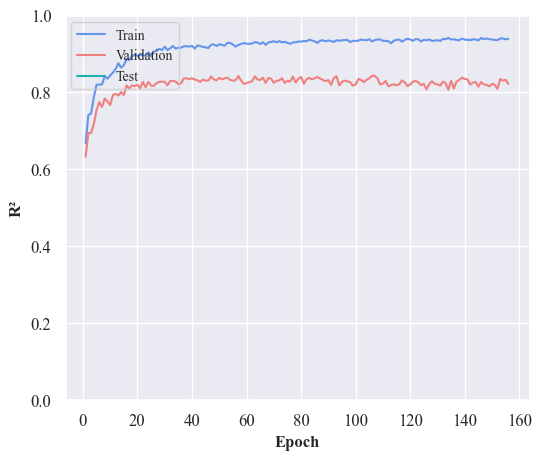

In [6]:
##########################################学习曲线###########################################

import matplotlib
matplotlib.rcParams['text.usetex'] = False
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(figsize=(6, 5), facecolor='w')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# 修改样式设置
plt.rc('axes', facecolor='none')  # 设置背景颜色为透明
plt.rc('axes', edgecolor='black')  # 设置坐标轴颜色为黑色
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.tick_params(axis='both', width=2, length=6)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
epochs = range(1, len(train_scores) + 1)
plt.plot(epochs, train_scores, color="cornflowerblue", label='Train')
plt.plot(epochs, val_scores, color="lightcoral", label='Validation')
plt.plot(epochs, test_scores, color="lightseagreen", label='Test')

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('R\u00b2', fontsize=12, fontweight='bold')
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize=10)
plt.savefig("ncan_r.jpg", dpi=1000, bbox_inches='tight', transparent=True)
plt.show()

In [22]:
##################################
early_stopping = EarlyStopping(pretrained_model='zhu_early_stop.pth', mode='higher', patience=20, filename='ncan_early_stop.pth', task_name='ncan')
    # 加载预训练模型参数到现有模型中
early_stopping.load_pretrained_model(model)
early_stopping.load_model_attention(model)

In [23]:
#输出模型的预测值
data_loader = train_loader
output_path = 'D:/科研/data/zhu_train_result-11-03-species4-7.csv'  # 设置输出路径
#评估模型
eval_results = run_an_eval_epoch_re(args, model, data_loader, output_path)

In [24]:
#输出模型的预测值
data_loader = val_loader
output_path = 'D:/科研/data/zhu_val_result-11-03-species4-7.csv'  # 设置输出路径
#评估模型
eval_results = run_an_eval_epoch_re(args, model, data_loader, output_path)

In [25]:
#输出模型的预测值
data_loader = test_loader
output_path = 'D:/科研/data/zhu_test_result-11-03-species4-7.csv'  # 设置输出路径
#评估模型
eval_results = run_an_eval_epoch_re(args, model, data_loader, output_path)